<a href="https://colab.research.google.com/github/kanakhan/GMSW/blob/main/LDA_%EC%8B%A4%EC%8A%B5(%EC%88%98%EC%97%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 파이썬을 이용한 LDA 과정


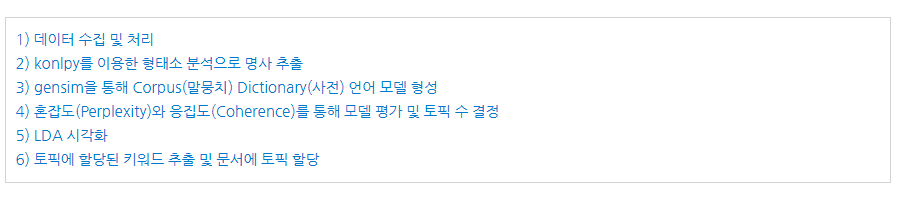

###### 데이터 수집 및 처리



In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

def get_movie_reviews(mcode,  page_num): 

  m_review_df = pd.DataFrame(columns=("Title", "Score","Review"))
  idx = 0


  for p in range(1, page_num+1):
    url = "https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=" \
    + str(mcode) + "&target=&page=" + str(p)
    print(url)
    m_page = requests.get(url)
    m_soup = BeautifulSoup(m_page.text, "html.parser")
    reviews = m_soup.find_all('td', {'class': 'title'})
    for review in reviews:
      title = review.find('a', {'class' : 'movie color_b'}).get_text()
      score = review.find('em').get_text()
      review_text = review.find('a', {'class': 'report'}).get('onclick').split(',')[2]
      m_review_df.loc[idx] = [title, score, review_text]
      idx += 1
      print("#", end="")
    page_num += 1
    
    try:
      url = "https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=" \
      + str(mcode) + "&target=&page" + str(page_num)
    except:
      break

  return m_review_df

In [2]:
m_review_df = get_movie_reviews(195758, 10)

https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=195758&target=&page=1
##########https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=195758&target=&page=2
##########https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=195758&target=&page=3
##########https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=195758&target=&page=4
##########https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=195758&target=&page=5
##########https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=195758&target=&page=6
##########https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=195758&target=&page=7
##########https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=195758&target=&page=8
##########https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=195758&target=&page=9
##########https://movie.naver.com/movie/point/af/list.naver?st=mcode&sword=195758&target=&page=10
##########

#### 데이터 정제

In [4]:
def text_clean(text):
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern, '', text)
    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern, '', text)
    pattern = '[a-zA-Z0-9]'    # 숫자와 알파벳 제거
    text = re.sub(pattern, '', text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern, '', text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern, '', text)
    pattern = '[^\w\s]'         # 특수기호제거
    text = re.sub(pattern, '', text)
    return text 

In [7]:
m_review_df.head()

,Title,Score,Review
0,헌트,1,'연기랑 캐스팅은 호화인데... '
1,헌트,8,'넷플릭스로 보면서 볼륨 높였다가 와이프가 소리 줄이래서 줄여서 보다가 대사 안들...
2,헌트,10,'고문기술자. 이근안을 모티브로 했겠죠? 그 역할 하신 분 고생 많으셨네요. 이정...
3,헌트,8,''
4,헌트,10,'듣던대로 기대이상이었다.'


In [5]:
import re

reviews = list(m_review_df.Review)
reviews = list(map(lambda x : text_clean(x), reviews))

#### konlpy를 이용한 형태소 분석으로 명사 추출


In [6]:
!pip install konlpy  

!curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 5.6 MB/s 
     |████████████████████████████████| 465 kB 45.3 MB/s 
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-release /etc/os-release
+ '[' '/etc/lsb-release:DISTRIB_ID=Ubuntu
/etc/lsb-release:DISTRIB_DESCRIPTION="Ubuntu 18.04.6 LTS"
/etc/os-release:NAME="Ubuntu"
/etc/os-release:ID=ubuntu
/etc/os-release:ID_LIKE=debian
/etc/os-release:PRETTY_NAME="Ubuntu 18.04.6 LTS"
/etc/os-release:HOME_URL="https://www.ubuntu.com/"
/etc/os-release

In [8]:
# Mecab 호출해 명사 토큰화 실시

from konlpy.tag import Mecab
mecab = Mecab()
tokens = list(map(lambda x : mecab.nouns(x), reviews))


t = []
n= []
for token in tokens:
  for noun in token:
    if len(noun) > 1:
      n.append(noun)
  t.append(list(n))

t[:10]
tokens = t
tokens[:3]

[['연기', '캐스팅', '호화'],
 ['연기', '캐스팅', '호화', '넷플릭스', '볼륨', '와이프', '소리', '대사', '볼륨', '재생', '반복', '혼자'],
 ['연기',
  '캐스팅',
  '호화',
  '넷플릭스',
  '볼륨',
  '와이프',
  '소리',
  '대사',
  '볼륨',
  '재생',
  '반복',
  '혼자',
  '고문',
  '기술자',
  '이근안',
  '모티브',
  '역할',
  '고생',
  '이정재',
  '대신',
  '감사']]

In [15]:
tokens[:10]

[['연기', '캐스팅', '호화'],
 ['연기', '캐스팅', '호화', '넷플릭스', '볼륨', '와이프', '소리', '대사', '볼륨', '재생', '반복', '혼자'],
 ['연기',
  '캐스팅',
  '호화',
  '넷플릭스',
  '볼륨',
  '와이프',
  '소리',
  '대사',
  '볼륨',
  '재생',
  '반복',
  '혼자',
  '고문',
  '기술자',
  '이근안',
  '모티브',
  '역할',
  '고생',
  '이정재',
  '대신',
  '감사'],
 ['연기',
  '캐스팅',
  '호화',
  '넷플릭스',
  '볼륨',
  '와이프',
  '소리',
  '대사',
  '볼륨',
  '재생',
  '반복',
  '혼자',
  '고문',
  '기술자',
  '이근안',
  '모티브',
  '역할',
  '고생',
  '이정재',
  '대신',
  '감사'],
 ['연기',
  '캐스팅',
  '호화',
  '넷플릭스',
  '볼륨',
  '와이프',
  '소리',
  '대사',
  '볼륨',
  '재생',
  '반복',
  '혼자',
  '고문',
  '기술자',
  '이근안',
  '모티브',
  '역할',
  '고생',
  '이정재',
  '대신',
  '감사',
  '대로',
  '기대',
  '이상'],
 ['연기',
  '캐스팅',
  '호화',
  '넷플릭스',
  '볼륨',
  '와이프',
  '소리',
  '대사',
  '볼륨',
  '재생',
  '반복',
  '혼자',
  '고문',
  '기술자',
  '이근안',
  '모티브',
  '역할',
  '고생',
  '이정재',
  '대신',
  '감사',
  '대로',
  '기대',
  '이상',
  '당시',
  '전두환'],
 ['연기',
  '캐스팅',
  '호화',
  '넷플릭스',
  '볼륨',
  '와이프',
  '소리',
  '대사',
  '볼륨',
  '재생',
  '반복',
  '혼자',
  '고문',
  '기술자',
  '이근안',


### LDA 토픽 모델링

###### gensim에서 사용할 BOW 생성

* LDA 토픽 모델링은 Bag of words(BoW)을 데이터로 사용
* 우선 텍스를 다루는 gensim 패키지인 corpora 를 사용해 토큰화된 단어와 gensim 내부 id와 매칭 시키는 단어 사전(dictionary)으로 만듦.
* gensim의 LDA에서 사용하는 BoW의 형태는 (단어 번호: index, 빈도)로 이뤄진 리스트 자료
* Dictionary 클래스에 doc2bow 메서드를 이용해 (index, 빈도) 형태의 리스트 BoW를 생성

In [9]:
!pip install gensim 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import gensim

from gensim import corpora

dictionary = corpora.Dictionary(tokens) # 토큰 단어와 gensim 내부 아이디 매칭
dictionary.filter_extremes(no_below=2, no_above=0.5) # 빈도 2이상 포함, 전체 50% 이상 단어 제거
corpus = [dictionary.doc2bow(token) for token in tokens] 

In [16]:
corpus

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(0, 1)],
 [(0, 1), (1, 1), (2, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 1)],
 [(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1)],
 [(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1)],
 [(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1)],
 [(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 2),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1)],
 [(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 2),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14,

#### LDA 모델링

* gensim의 LAD는 gensim.models.LdaModel을 사용해 모델링

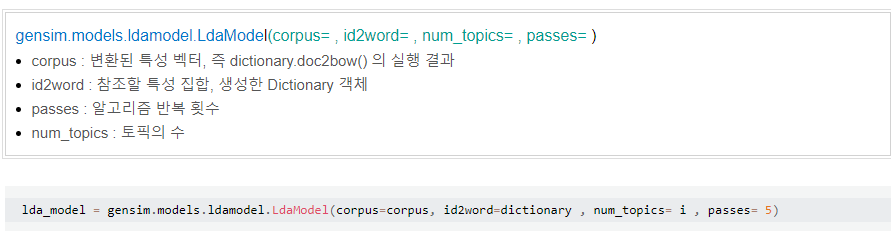

#### Coherence 모델링(토픽 수 결정)

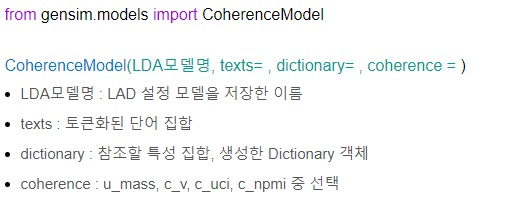

In [17]:
from gensim.models import CoherenceModel

coherence_score=[]

for i in range(2,10):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=i, passes= 5)
    coherence_model = CoherenceModel(model, texts=tokens, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    print('k=',i,'\nCoherence Score: ', coherence_lda)
    coherence_score.append(coherence_lda)

k= 2 
Coherence Score:  0.9012707887815359


k= 3 
Coherence Score:  0.7735295429272536


k= 4 
Coherence Score:  0.7750642521118685


k= 5 
Coherence Score:  0.7966681856738171


k= 6 
Coherence Score:  0.8092660796048623


k= 7 
Coherence Score:  0.76658028828314


k= 8 
Coherence Score:  0.848887698829621
k= 9 
Coherence Score:  0.8228323016920841


* cohrence 그래프로 확인

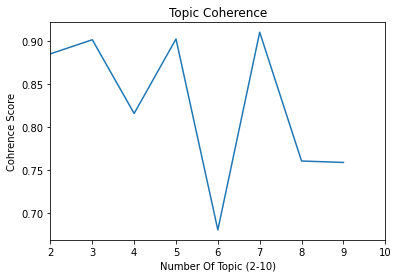

In [12]:
import matplotlib.pyplot as plt
import numpy

k=[]
for i in range(2,10):
    k.append(i)
x= k
y=coherence_score
plt.title('Topic Coherence')
plt.plot(x,y)
plt.xlim(2,10)
plt.xlabel('Number Of Topic (2-10)')
plt.ylabel('Cohrence Score')
plt.show()

### 최종 LDA 모형 선택

In [18]:
final_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=2, passes= 5)
final_model.print_topics()

[(0,
  '0.029*"구성" + 0.025*"교화" + 0.025*"사망" + 0.023*"봉작" + 0.023*"메오" + 0.022*"소재" + 0.018*"깜놀" + 0.018*"흥미" + 0.018*"초반" + 0.017*"세력"'),
 (1,
  '0.059*"봉작" + 0.056*"구성" + 0.037*"메오" + 0.033*"각하" + 0.033*"성공" + 0.032*"데뷔작" + 0.030*"디테일" + 0.030*"배역" + 0.029*"치곤" + 0.029*"검색"')]

#### LDA 모델 시각화

* LDA 시각화를 위해 파이썬에서 가장 많이 사용되는 패키지는 pyLDAvis

In [14]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=c6ebdd92f64294fe351203db0bac26cfbe94caa287963c045971ebadbea782f6
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=cbaf05a486fd20cc75654f838cc6c66f99f8dc5dfb87ae9c3c229da61c9bcd35
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [19]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

prepared_data = gensimvis.prepare(final_model, corpus, dictionary)
pyLDAvis.display(prepared_data)

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
